# The Efficient Frontier & Capital Market Line

__Project Objectives:__ 
- Find the optimal portfolio allocation to achieve the maximum Sharpe Ratio or minimum volatility given some list of assets.
- Allocate efficiently between the the risk-free asset and the global optimal portfolio on the Capital Market Line accoridng to user-defined risk or reward preferences.
- Plot where a user-defined allocation falls with respect to the efficient frontier.

In [1]:
# package imports
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import requests
from tqdm import tqdm 
import scipy as sc
import seaborn as sns
import warnings
import os

In [2]:
def get_tbill_yields(code = 'V80691346'): #this code returns the 1 Year T Bill Yields
    ''' fetches the most recent tbill yields from the Bank of Canada API
    args: 
        (string) Bank of Canada API code for desired time series
    return:
        (pandas.DataFrame) T-bill yields indexed by dates
    '''
    url = f'https://www.bankofcanada.ca/valet/observations/' + code
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
    else:
        print("Failed to retrieve data:", response.status_code)
    dates, values = [], []
    for elem in data['observations']:
        dates.append(pd.to_datetime(elem['d']))
        values.append(float(elem[code]['v'])/100)
    return pd.DataFrame({'tbill_yields':values}, index=dates)

## 1. User-Defined Model Inputs

| Variable | Definition |
|:---|:---|
|tickers_file | (string) A .csv file containing the list of assets to consider as part of portfolio. |
|risk_free_rate | (float) The risk-free rate. Currently updates automatically from BoC API, but can be user defined. |
|numb_years_historical_data | (float) The lookback period to consider in generating historical returns and volatility. |
|constraint_set | (tuple) constraints on the weights for all assets. |
|output_folder | (string) specify an output folder to store results. If folder does not exist, it will be created. |
|desired_return | (float) desired return for Capital Marklet Line portfolio. If not None, desired_volatility must be None as it will be solved for.|
|desired_volatility | (float) desired volatility for Capital Marklet Line portfolio. If not None, desired_return must be None as it will be solved for.|                                            

In [3]:
tickers_file = 'tickers.csv'
risk_free_rate = get_tbill_yields().iloc[-1].values[0]
numb_years_historical_data = 5
constraint_set = (0,1) # weights vary between 0 and 1, ie no short selling
output_folder = 'outputs/efficient-allocation'
desired_return = None
desired_volatility = 0.05

## 2. Helper Functions

| Function| Definition |
|:---|:---|
|get_data(tickers, start, end) | Calculates mean returns and covariance matrix for list of tickers. |
|portfolio_returns(weights) | Calculates annualized portfolio returns. |
|portfolio_volatility(weights) | Calculates annualized portfolio volatility. |
|negative_sharpe_ratio(weights) | Calculates the negative Sharpe Ratio to be minimized. |
|minimize_func(func, return_target) | Minimizes the given function (subject to return_target, if given). |
|create_efficient_frontier(n_returns) | Collects inputs to construct the efficient frontier. |
|CML_portfolio(market_portfolio_allocation, desired_return, desired_volatility) | Calculates the weights of a desired portfolio on the Capital Market Line. | 

In [4]:
def get_data(tickers, start, end):
    '''calculates mean returns and covariance matrix for list of tickers
    args:
        (list) tickers list upon which to construct an efficient portfolio
        (datetime) start date of the lookback period
        (datetime) end date of the lookback period
    return:
        (pd.Series) mean return for each ticker
        (pd.DataFrame) covariance matrix
        (pd.DataFrame) correlation matrix
    '''
    stock_data = yf.download(tickers, start=start, end=end)
    stock_data = stock_data['Adj Close']
    returns = np.log(stock_data).diff()
    
    mean_returns = returns.mean()
    covariance_matrix = returns.cov()
    correlation_matrix = returns.corr()
    
    return mean_returns, covariance_matrix, correlation_matrix

def portfolio_returns(weights):
    '''calculates annualized portfolio returns
    args:
        (list) list of weights to calculate the portfolio return
    return:
        (float) portfolio return
    '''
    weights = np.array(weights).flatten()
    return np.sum(mean_returns*weights)*252

def portfolio_volatility(weights):
    '''calculates annualized portfolio volatility
    args:
        (list) list of weights to calculate the portfolio volatility
    return:
        (float) portfolio volatility
    '''
    weights = np.array(weights).flatten()
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))*np.sqrt(252)

def negative_sharpe_ratio(weights):
    '''calculates the negative Sharpe Ratio to be minimized
    args:
        (list) list of weights to calculate the portfolio return & volatility
    return:
        (float) portfolio sharpe ratio (negated because we will be using SciPy's minimizer)
    '''
    portfolio_ret, portfolio_std =  portfolio_returns(weights), portfolio_volatility(weights)
    return -(portfolio_ret - risk_free_rate)/portfolio_std

def minimize_func(func, return_target = None):
    '''minimizes the given function (subject to return_target, if given)
    args:
        (function) the function to minimize, ie negative_sharpe_ratio or portfolio_volatility
        (optional, float) minimizes function subject to achieving the return target
    return:
        (SciPy.optimize) result object of the minimization which includes the weight allocation for the minima of the function
    '''
    if return_target is None:
        constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})
    else:
        constraints = ({'type':'eq', 'fun':lambda x: portfolio_returns(x) - return_target},
                        {'type':'eq', 'fun': lambda x: np.sum(x)-1})
    result = sc.optimize.minimize(func, 
                                  n*[1./n],  
                                  method = 'SLSQP', 
                                  bounds=bounds, 
                                  constraints=constraints)
    return result       

def create_efficient_frontier(n_returns = 100):
    '''collects inputs to construct the efficient frontier
    args:
        (optional, int) granularity of the efficient frontier curve
    return:
        (pd.DataFrame) return and volatility for max sharpe ratio portfolio, return and volatility for minimum volatility portfolio
        (pd.DataFrame) weight allocation for max sharpe ratio portfolio 
        (pd.DataFrame) weight allocation for min volatility portfolio 
        (list) volatility list for portfolios on the efficient frontier
        (list) returns corresponding to volatilities for portfolios on the efficient frontier
    '''
    
    #Max Sharpe Ratio Portfolio
    max_sharpe_ratio_portfolio = minimize_func(negative_sharpe_ratio)
    max_sharpe_ratio_returns, max_sharpe_ratio_std = portfolio_returns(max_sharpe_ratio_portfolio['x']), portfolio_volatility(max_sharpe_ratio_portfolio['x'])
    max_sharpe_ratio_allocation = pd.DataFrame(max_sharpe_ratio_portfolio['x'], index=mean_returns.index, columns=['Max Sharpe Ratio Allocation'])
    
    #Min Volatility Portfolio
    min_volatility_portfolio = minimize_func(portfolio_volatility)
    min_volatility_returns, min_volatility_ratio_std = portfolio_returns(min_volatility_portfolio['x']), portfolio_volatility(min_volatility_portfolio['x'])
    min_volatility_allocation = pd.DataFrame(min_volatility_portfolio['x'], index=mean_returns.index, columns=['Min Volatility Allocation'])
    
    #Efficient Frontier
    efficient_list = []
    target_returns = np.linspace(min_volatility_returns*0.9, max_sharpe_ratio_returns*1.1, n_returns)
    for target in tqdm(target_returns):
        efficient_list.append(minimize_func(portfolio_volatility, target)['fun'])
        
    results = pd.DataFrame({'max_SR_ret':[max_sharpe_ratio_returns],
                           'max_SR_std':[max_sharpe_ratio_std],
                           'min_vol_ret':[min_volatility_returns],
                           'min_vol_std':[min_volatility_ratio_std]})
    
    return results, max_sharpe_ratio_allocation, min_volatility_allocation, efficient_list, target_returns

def CML_portfolio(market_portfolio_allocation, desired_return = None, desired_volatility = None):
    '''calculates the weights of a desired portfolio on the Capital Market Line and solves for desired_return if desired_volatility given (and vice-versa)
    args:
        (numpy.array) weights of the max Sharpe Ratio portfolio
        (optional, float) desired return target for CML portfolio. If not None, will solve for desired_volatility.
        (optional, float) desired volatility target for CML portfolio. If not None, will solve for desired_volatility.
    return:
        (float) portfolio return
        (float) portfolio volatility
        (float) portfolio Sharpe Ratio
        (float) weight in the risk-free asset
        (float) weight in the risky asset
    '''
    ret, std = portfolio_returns(market_portfolio_allocation), portfolio_volatility(market_portfolio_allocation)
    if desired_return is None and desired_volatility is None:
        weight_risky_asset = 1
        weight_risk_free_asset = 0
    elif desired_return is not None and desired_volatility is not None:
        warnings.warn('Please specify either a desired return or a desired volatility, but not both.')
        return [None]*5
    elif desired_return is not None:
        weight_risk_free_asset = (desired_return - ret)/(risk_free_rate - ret)
        weight_risky_asset = (1 - weight_risk_free_asset)
    elif desired_volatility is not None:
        weight_risky_asset = desired_volatility/std
        weight_risk_free_asset = (1 - weight_risky_asset)
    port_ret = weight_risk_free_asset*risk_free_rate + weight_risky_asset*ret
    port_std = weight_risky_asset*std
    cml_sr = (port_ret - risk_free_rate)/port_std
    return port_ret, port_std, cml_sr, weight_risk_free_asset, weight_risky_asset     

## 3. Execute Model

In [5]:
# read in tickers file and create a list of tickers 
missing_values = ["", "#N/A", "NULL", "N/A"]
ticker_df = pd.read_csv(tickers_file, na_values=missing_values, keep_default_na=False)
tickers = list(ticker_df.ticker + '.' + ticker_df.exchange)
# if tickers file makes expected returns available, will use those in place of historical returns
expected_returns = pd.Series(ticker_df.expected_returns)
expected_returns.index = tickers  
# define the start and end dates for the lookback period
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=int(numb_years_historical_data*365)) 
# fetch the data using yfinance and populate global variables   
mean_returns, covariance_matrix, correlation_matrix = get_data(tickers, start=start_date, end=end_date)
mean_returns = mean_returns.where(expected_returns.isna(), expected_returns) # replaces mean_returns with estimate where available, otherwise uses historical data
n = len(mean_returns)
bounds = tuple(constraint_set for asset in range(n))
# example of a random sub-optimal portfolio. User can also specify specific allocation in tickers file.
current_allocation = np.random.rand(n)#ticker_df.current_allocation.values.flatten()
current_allocation /= np.sum(current_allocation)
current_allocation_exists = all(not np.isnan(x) for x in list(current_allocation))
if current_allocation_exists:
    curr_returns, curr_std = portfolio_returns(current_allocation), portfolio_volatility(current_allocation) 
    current_allocation = pd.Series(current_allocation, index=tickers, name='Current Allocation')

# Create the Efficient Frontier and output quantities
results, max_sharpe_ratio_allocation, min_volatility_allocation, efficient_list, target_returns = create_efficient_frontier()

[*********************100%%**********************]  60 of 60 completed


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.22it/s]


## 4. Outputs

### 4.1 Main Plot: The Efficient Frontier & Capital Market Line

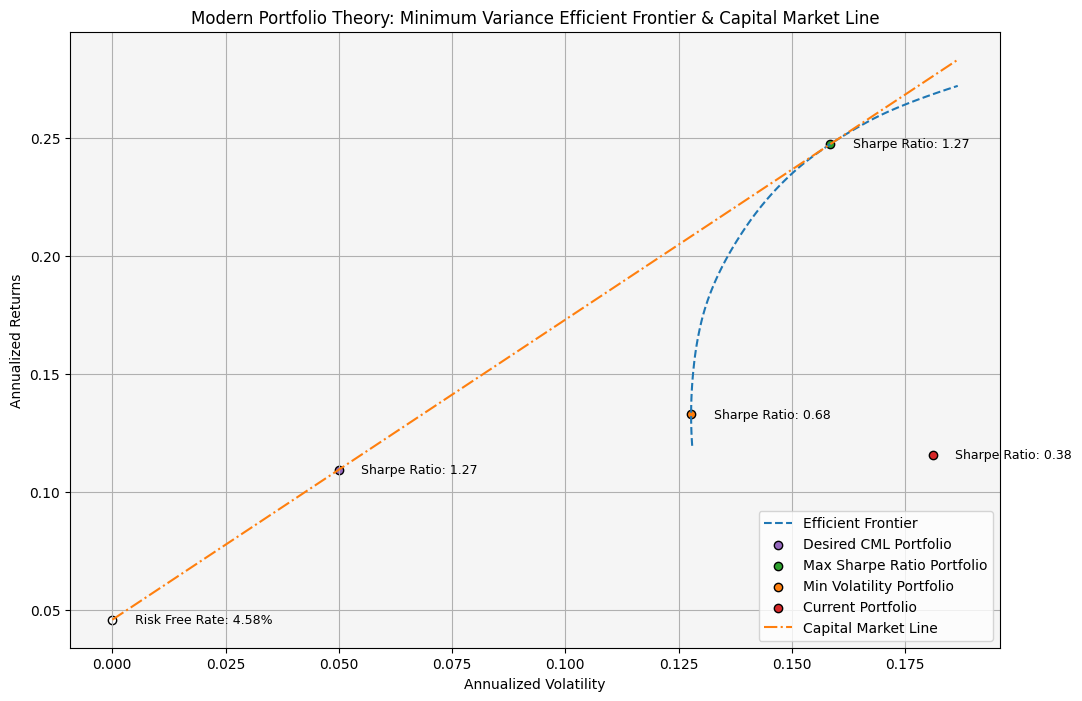

In [6]:
# makes an output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

plt.figure(figsize=(12, 8))
plt.plot(efficient_list, target_returns, linestyle='--', label='Efficient Frontier')

cml_allocation = None
if (desired_return is not None) or (desired_volatility is not None):
    desired_return, desired_std, cml_sr, weight_risk_free_asset, weight_risky_asset = CML_portfolio(max_sharpe_ratio_allocation, desired_return, desired_volatility)
    if cml_sr is not None:
        assert weight_risk_free_asset == 1 or round(cml_sr,6) == round(-negative_sharpe_ratio(max_sharpe_ratio_allocation),6) #validation check to assure Sharpe Ratio on CML is always equal to global maximum Sharpe Ratio
        plt.scatter(desired_std, desired_return, color='tab:purple', label = 'Desired CML Portfolio', edgecolors='black', linewidths=1)
        if weight_risk_free_asset == 1:
            plt.text(desired_std+0.005, desired_return, 'Sharpe Ratio: '+str(0), fontsize=9, verticalalignment='center')    
        else:    
            plt.text(desired_std+0.005, desired_return, 'Sharpe Ratio: '+str(round(cml_sr,2)), fontsize=9, verticalalignment='center') 
        cml_allocation = pd.DataFrame({'Weights':[round(weight_risk_free_asset,4), round(weight_risky_asset,4)]}, index=['Risk Free Asset','Max Sharpe Ratio Portfolio'])

plt.scatter(0, risk_free_rate, color='white', edgecolors='black', linewidths=1) 
plt.text(0+0.005, risk_free_rate, 'Risk Free Rate: '+str(round(risk_free_rate*100,2))+'%', fontsize=9, verticalalignment='center')

plt.scatter(results.max_SR_std, results.max_SR_ret, color='tab:green', label = 'Max Sharpe Ratio Portfolio', edgecolors='black', linewidths=1)
plt.text(results.max_SR_std.values+0.005, results.max_SR_ret.values, 'Sharpe Ratio: '+str(round(-negative_sharpe_ratio(max_sharpe_ratio_allocation),2)), fontsize=9, verticalalignment='center')

plt.scatter(results.min_vol_std, results.min_vol_ret, color='tab:orange', label = 'Min Volatility Portfolio', edgecolors='black', linewidths=1)
plt.text(results.min_vol_std.values+0.005, results.min_vol_ret.values, 'Sharpe Ratio: '+str(round(-negative_sharpe_ratio(min_volatility_allocation),2)), fontsize=9, verticalalignment='center')

if current_allocation_exists:
    plt.scatter(curr_std, curr_returns, color='tab:red', label = 'Current Portfolio', edgecolors='black', linewidths=1)
    plt.text(curr_std+0.005, curr_returns, 'Sharpe Ratio: '+str(round(-negative_sharpe_ratio(current_allocation),2)), fontsize=9, verticalalignment='center')    

cml = risk_free_rate + (results.max_SR_ret[0] - risk_free_rate)*(np.array([0,efficient_list[-1]])/results.max_SR_std[0]) # Capital Market Line
plt.plot(np.array([0,efficient_list[-1]]), cml, linestyle='-.', label='Capital Market Line')

plt.title('Modern Portfolio Theory: Minimum Variance Efficient Frontier & Capital Market Line')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Returns')
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.gca().patch.set_alpha(0.075)
plt.legend(loc='lower right')

save_path = os.path.join(output_folder, 'efficient_frontier.png')
plt.savefig(save_path)    
plt.show()

### 4.2: Correlation Matrix

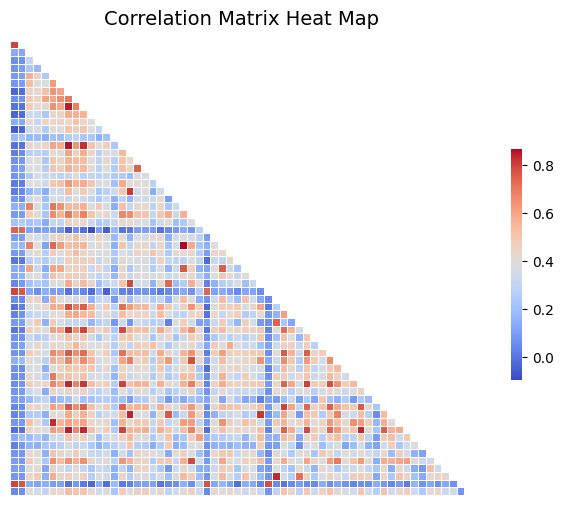

In [7]:
correlation_matrix.round(4).to_csv('./'+output_folder+'/correlation_matrix.csv')
plt.figure(figsize=(10, 6))
if len(correlation_matrix) > 10: #too large to display numbers. display heatmap only and output correlation matrix as .csv file
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, cbar=True, xticklabels=False, yticklabels=False)
else:
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heat Map', fontsize=14)
save_path = os.path.join(output_folder, 'correlation_matrix_heat_map.png')
plt.savefig(save_path)    
plt.show()

### 4.3: Portfolio Allocations

In [8]:
# Keep only tickers with non-zero weights
merged_df = pd.merge(max_sharpe_ratio_allocation[max_sharpe_ratio_allocation['Max Sharpe Ratio Allocation'] > 0], 
                     min_volatility_allocation[min_volatility_allocation['Min Volatility Allocation'] > 0], left_index=True, right_index=True, how='outer')
if current_allocation_exists:
    merged_df = pd.merge(merged_df, current_allocation, left_index=True, right_index=True, how='outer')
merged_df.fillna(0, inplace=True)
merged_df = np.round(merged_df,4)
merged_df.to_csv('./'+output_folder+'/allocations.csv')
display(merged_df)

,Max Sharpe Ratio Allocation,Min Volatility Allocation,Current Allocation
ABX.TO,0.0000,0.0174,0.0107
AEM.TO,0.0000,0.0000,0.0065
AQN.TO,0.0000,0.0000,0.0052
ATD.TO,0.0000,0.0000,0.0093
BAM.TO,0.0000,0.0743,0.0280
BCE.TO,0.0000,0.0000,0.0098
BIP-UN.TO,0.0000,0.0000,0.0290
BMO.TO,0.0000,0.0000,0.0168
BN.TO,0.0000,0.0000,0.0256
BNS.TO,0.0000,0.0000,0.0146


### 4.4: Capital Market Line Allocation

In [9]:
cml_allocation.to_csv('./'+output_folder+'/desired_cml_allocation.csv')
display(cml_allocation)

,Weights
Risk Free Asset,0.6845
Max Sharpe Ratio Portfolio,0.3155


## 5. Future Improvements

| Todo | Description |
|:---|:---|
|Expected Volatility | Implement optional MGARCH model for covariance matrix based on expected volatility rather than historical volatility. |
|Factor Models | Implement optional factor model for expected returns based on changing market conditions rather than historical returns. |
|Specific Asset Constraints | Allow for asset-specific constraints rather than the current global constraints and for more diverse constraint otions. |
|Plot Arbitrary Portfolio | Allow user to solve for (and plot) an arbitrary portfolio, including on the efficient frontier. |
|Codebase | Rewrite codebase for reusability across classes and a runtime parameter file. |
|Graphical User Interface | Create an interactive GUI with Plotly allowing user to use sliders to adjust parameters and import files. |